### Plane-wave regularized least-squares interpolation
#### Author: Francesco Brandolin

This notebook presents the example for Plane-wave Least-squares regularized interpolation for synthetic data.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
from pylops.utils.wavelets import ricker
from scipy import signal, ndimage
from pinnslope.utils import snr, mse

### Data preparation and initial settings:

- crop = True : crops the loaded shot gather


Data shape: (201, 401)
Cropped Data shape: (119, 211)
Rop (5064, 25109)
Rop shape (5064, 25109)
data_obs shape (211, 24)


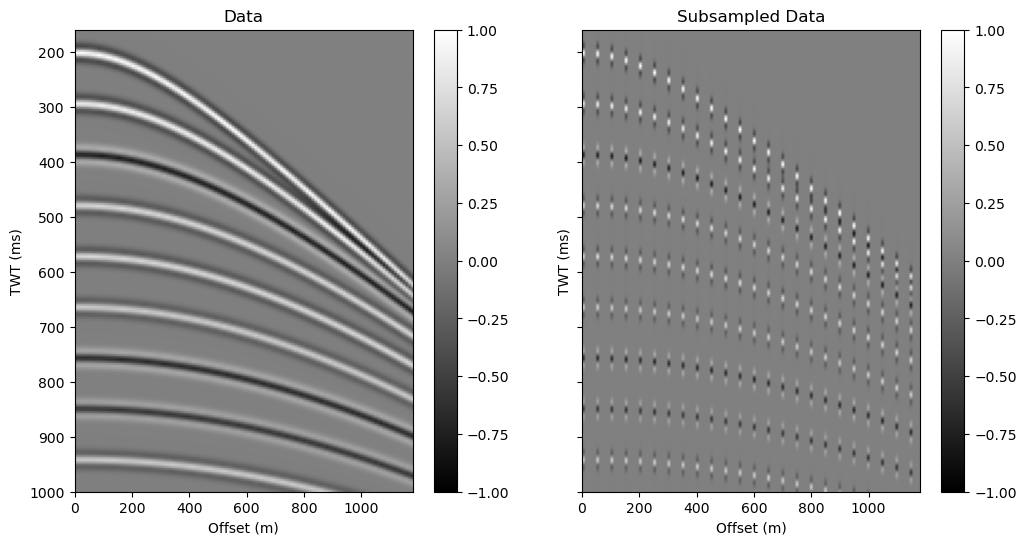

slope shape: (401, 201)
cropped slope shape: (211, 119)
slope_resh shape (25109, 1)


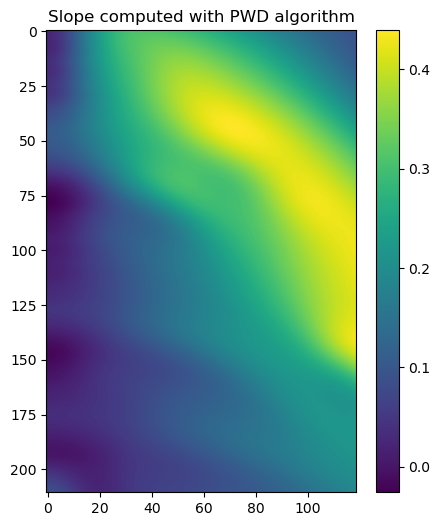

In [7]:
#Loading data:
path = "../data/synth_data/data_dense.npy"
data = np.load(path)
print('Data shape:',data.shape)

# Choose subsampling:
nsub = 5

# crop the shot-gather for faster testing:
crop = True


if crop==True:
    # Defining crop params:    
    x_start=0; x_end=119; t_start=40; t_end=251
    data =data[ x_start:x_end, t_start:t_end ]
    print('Cropped Data shape:',data.shape)

    ox, dx, nx = x_start, 10, x_end;  ot, dt, nt = t_start, 0.004, t_end
    dim_x = int(nx-ox); dim_t = int(nt-ot)
    x = (np.arange(dim_x)+ ox)* dx
    x = np.reshape(x, (dim_x, 1) )
    t = ((np.arange(dim_t)+ ot) * dt)*1e3
    t = np.reshape(t, (dim_t, 1) )
    
else:
    # Defining full shot-gather params:
    ox, dx, nx = 0, 10, 201;  ot, dt, nt = 0, 0.004, 401
    dim_x = int(nx-ox); dim_t = int(nt-ot) 
    x = (np.arange(dim_x)+ ox)* dx
    x = np.reshape(x, (dim_x, 1) )
    t = ((np.arange(dim_t)+ ot) * dt)*1e3
    t = np.reshape(t, (dim_t, 1) )


# Create restriction operator:
traces_index = np.arange( dim_x ); traces_index_sub = traces_index[::nsub]
Rop = pylops.Restriction( [dim_x, dim_t] , iava=traces_index_sub, axis=0, dtype="float64" ); print('Rop',Rop.shape)
print('Rop shape',Rop.shape)

# Apply restriction operator:
data_obs = Rop * (data).ravel()
nxsub = int(np.ceil(data.shape[0]/nsub))
data_obs = data_obs.reshape(nxsub, dim_t); data_obs = data_obs.T
print('data_obs shape',data_obs.shape)

# mask attribute for plotting:
datamask = Rop.mask(data.ravel())

# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

CMP = axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask.data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('Subsampled Data')
fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')
plt.show()



slope = np.load('../data/synth_data/SynthData5_low_freq_slope.npy')
# slope scaling factor:
slope = ((dt*1e3)/dx)*slope.T
print('slope shape:',slope.shape)
if crop == True:
    slope = slope[ t_start:t_end , x_start:x_end]; print('cropped slope shape:',slope.shape)

slope_resh = np.reshape(slope.T, (slope.shape[0]*slope.shape[1],1))
print('slope_resh shape', slope_resh.shape)

plt.figure(figsize=(5,6))
plt.imshow(slope)
plt.axis('tight')
plt.title('Slope computed with PWD algorithm')
plt.colorbar()
plt.show()

#### Plane-wave regularized least-squares interpolation
Here, we want to show the interpolation capabilities of a simple least-squares inversion regularized with the local plane-wave equation.

First, the regularization operator is formed "PWreg". Then, the system of regularized equations is solved given the restriction operator "Rop".

(-0.049579831932773114, 0.049579831932773114, -100.59760956175299, 0.0)

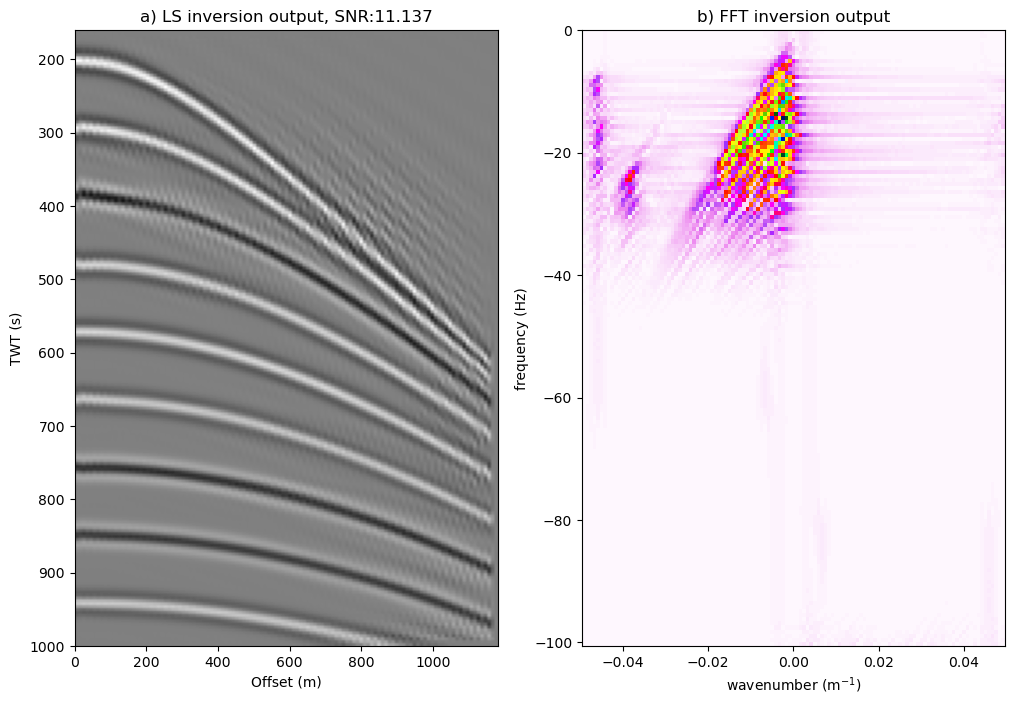

In [8]:
# Plane-Wave equation regularization:
D1op0 = pylops.FirstDerivative(dims=( dim_x, dim_t ), axis=0, sampling=10, order=5, dtype="float64")
D1op1 = pylops.FirstDerivative(dims=( dim_x, dim_t ), axis=1, sampling=4, order=5, dtype="float64")

slope_D1op1 = pylops.LinearOperator(pylops.Diagonal(slope_resh)*D1op1)
PWreg = D1op0 + slope_D1op1

# Solver:
xinv = pylops.optimization.leastsquares.regularized_inversion( Rop, (data_obs.T).ravel(), [PWreg], epsRs=[np.sqrt(1e-4)], **dict(iter_lim=500) )
inv = np.reshape(xinv[0], (data.shape[0],data.shape[1]))

# FFT:
Drec2 = np.fft.fft2(inv.T)
f, kx = np.fft.fftfreq(nt, dt), np.fft.fftfreq(nx, dx)

limit_plot = 150

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(inv.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('a) LS inversion output, SNR:{}'.format( round(snr(data.T, inv.T),3) ))
axs[0].axis('tight')

axs[1].imshow(np.fft.fftshift(np.abs(Drec2[:limit_plot]), axes=1),cmap = 'gist_ncar_r', vmin=np.min(np.abs(Drec2[:limit_plot])), vmax=400,
              extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[1].set_ylabel('frequency (Hz)')
axs[1].set_title('b) FFT inversion output')
axs[1].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)')
axs[1].axis('tight')


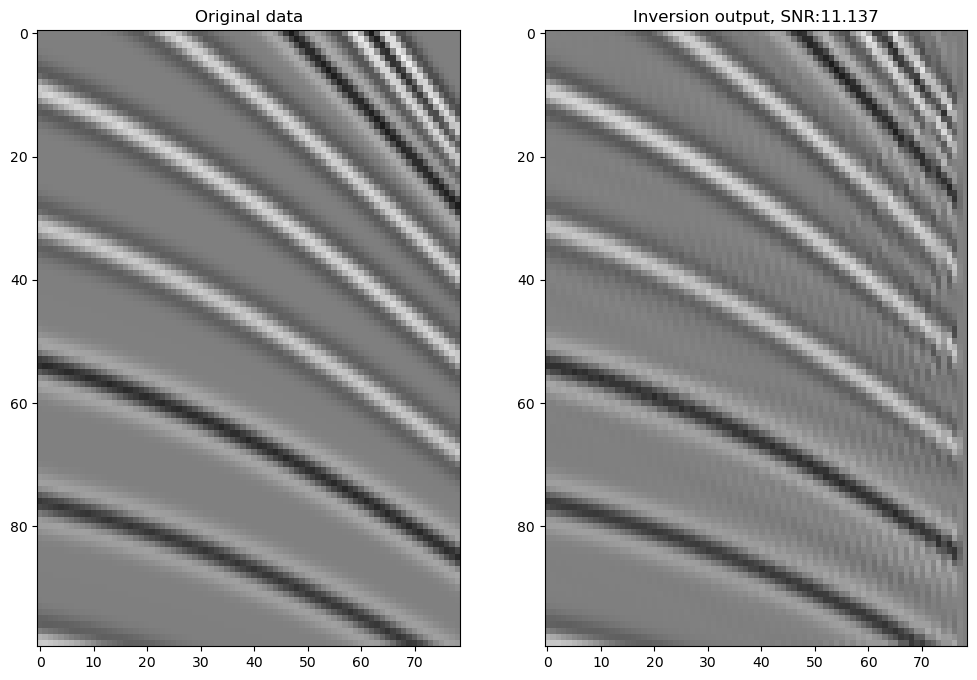

In [9]:
# Zoom in:

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
a=(data.T)
axs[0].imshow(a[100:200,40:], cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('Original data')
axs[0].axis('tight')

axs[1].imshow(inv.T[100:200,40:], cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Inversion output, SNR:{}'.format( round(snr(data.T, inv.T),3) ))
axs[1].axis('tight')
plt.show()

np.save('../data/Results/SynthResults/PWDLSinv.npy', inv)